In [1]:
# Load necessary modules and dataset 
import sys
sys.path.append(r"/mnt/ceph/users/tudomlumleart/00_VirtualEnvironments/teeu/lib/python3.10/site-packages")
sys.path.append(r"/mnt/home/tudomlumleart/.local/lib/python3.10/site-packages/")
sys.path.append(r"/mnt/home/tudomlumleart/ceph/00_VirtualEnvironments/jupyter-gpu/lib/python3.10/site-packages")

import matplotlib.pyplot as plt
from functions import *
from utils import *

import corner
import csv
import re

In [2]:
def extract_integer(folder_name):
    return [int(num) for num in re.findall(r'\d+', folder_name)]

In [16]:
results_dir = '/mnt/home/tudomlumleart/ceph/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/MCMC_results'
# list all folders in the results directory
# only keep the folders whose name starts with dataset


folders = [os.path.join(results_dir, f)
           for f in os.listdir(results_dir) if os.path.isdir(os.path.join(results_dir, f)) and f.startswith('dataset')]

In [17]:
# For each folder, list all the subfolders
folders = [os.path.join(f, subfolder, 'stan_output') for f in folders for subfolder in os.listdir(f) if os.path.isdir(os.path.join(f, subfolder))]

In [18]:
folders = sorted(folders, key=extract_integer)

In [19]:
folders

['/mnt/home/tudomlumleart/ceph/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/MCMC_results/dataset_100_10_20_2_0_2/0/stan_output',
 '/mnt/home/tudomlumleart/ceph/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/MCMC_results/dataset_100_10_20_2_0_2/1/stan_output',
 '/mnt/home/tudomlumleart/ceph/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/MCMC_results/dataset_100_10_20_2_0_2/2/stan_output',
 '/mnt/home/tudomlumleart/ceph/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/MCMC_results/dataset_100_10_20_2_0_2/3/stan_output',
 '/mnt/home/tudomlumleart/ceph/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/MCMC_results/dataset_100_10_20_2_0_2/4/stan_output',
 '/mnt/home/tudomlumleart/ceph/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/MCMC_results/dataset_100_10_20_2_0_2/5/stan_output',
 '/mnt/home/tudomlumleart/ceph/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/MCMC_results/dataset_100_10_20_2_0_2/6

In [48]:
stan_directory = folders[35]
print(stan_directory)

log_weights = []
lp = []
files = sorted(os.listdir(stan_directory))[-4:]
print(files)

/mnt/home/tudomlumleart/ceph/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/MCMC_results/dataset_100_10_20_2_0_2/35/stan_output
['20240715_WeightOptimization-20240715230619_1.csv', '20240715_WeightOptimization-20240715230619_2.csv', '20240715_WeightOptimization-20240715230619_3.csv', '20240715_WeightOptimization-20240715230619_4.csv']


In [49]:
def extract_specific_number(path, position):
    # Extract the segment that contains the numbers
    match = re.search(r'dataset_([\d_]+)/', path)
    if match:
        # Split the numbers and return the desired position
        numbers = match.group(1).split('_')
        if 0 <= position < len(numbers):
            return int(numbers[position])
    return None


In [50]:
num_metastructures = extract_specific_number(stan_directory, 3)

In [51]:
log_weights_d = []
for file in files:
    log_weights_chain = []
    lp_chain = []
    with open('%s/%s'%(stan_directory, file), newline='') as csvfile:
        reader = csv.DictReader(filter(lambda row: row[0]!='#', csvfile), )
        for row in reader:
            log_weights_row = [float(row["log_weights.%d"%i]) for i in range(1,num_metastructures+1)]
            lp_chain.append(float(row["lp__"]))
            log_weights_chain.append(log_weights_row)
    log_weights = np.array(log_weights_chain)
    lp_chain = np.array(lp_chain)
    log_weights_d.append(log_weights)
    lp.append(lp_chain)
log_weights_d = np.array(log_weights_d)


In [52]:
log_weights_d.shape

(4, 1000, 2)

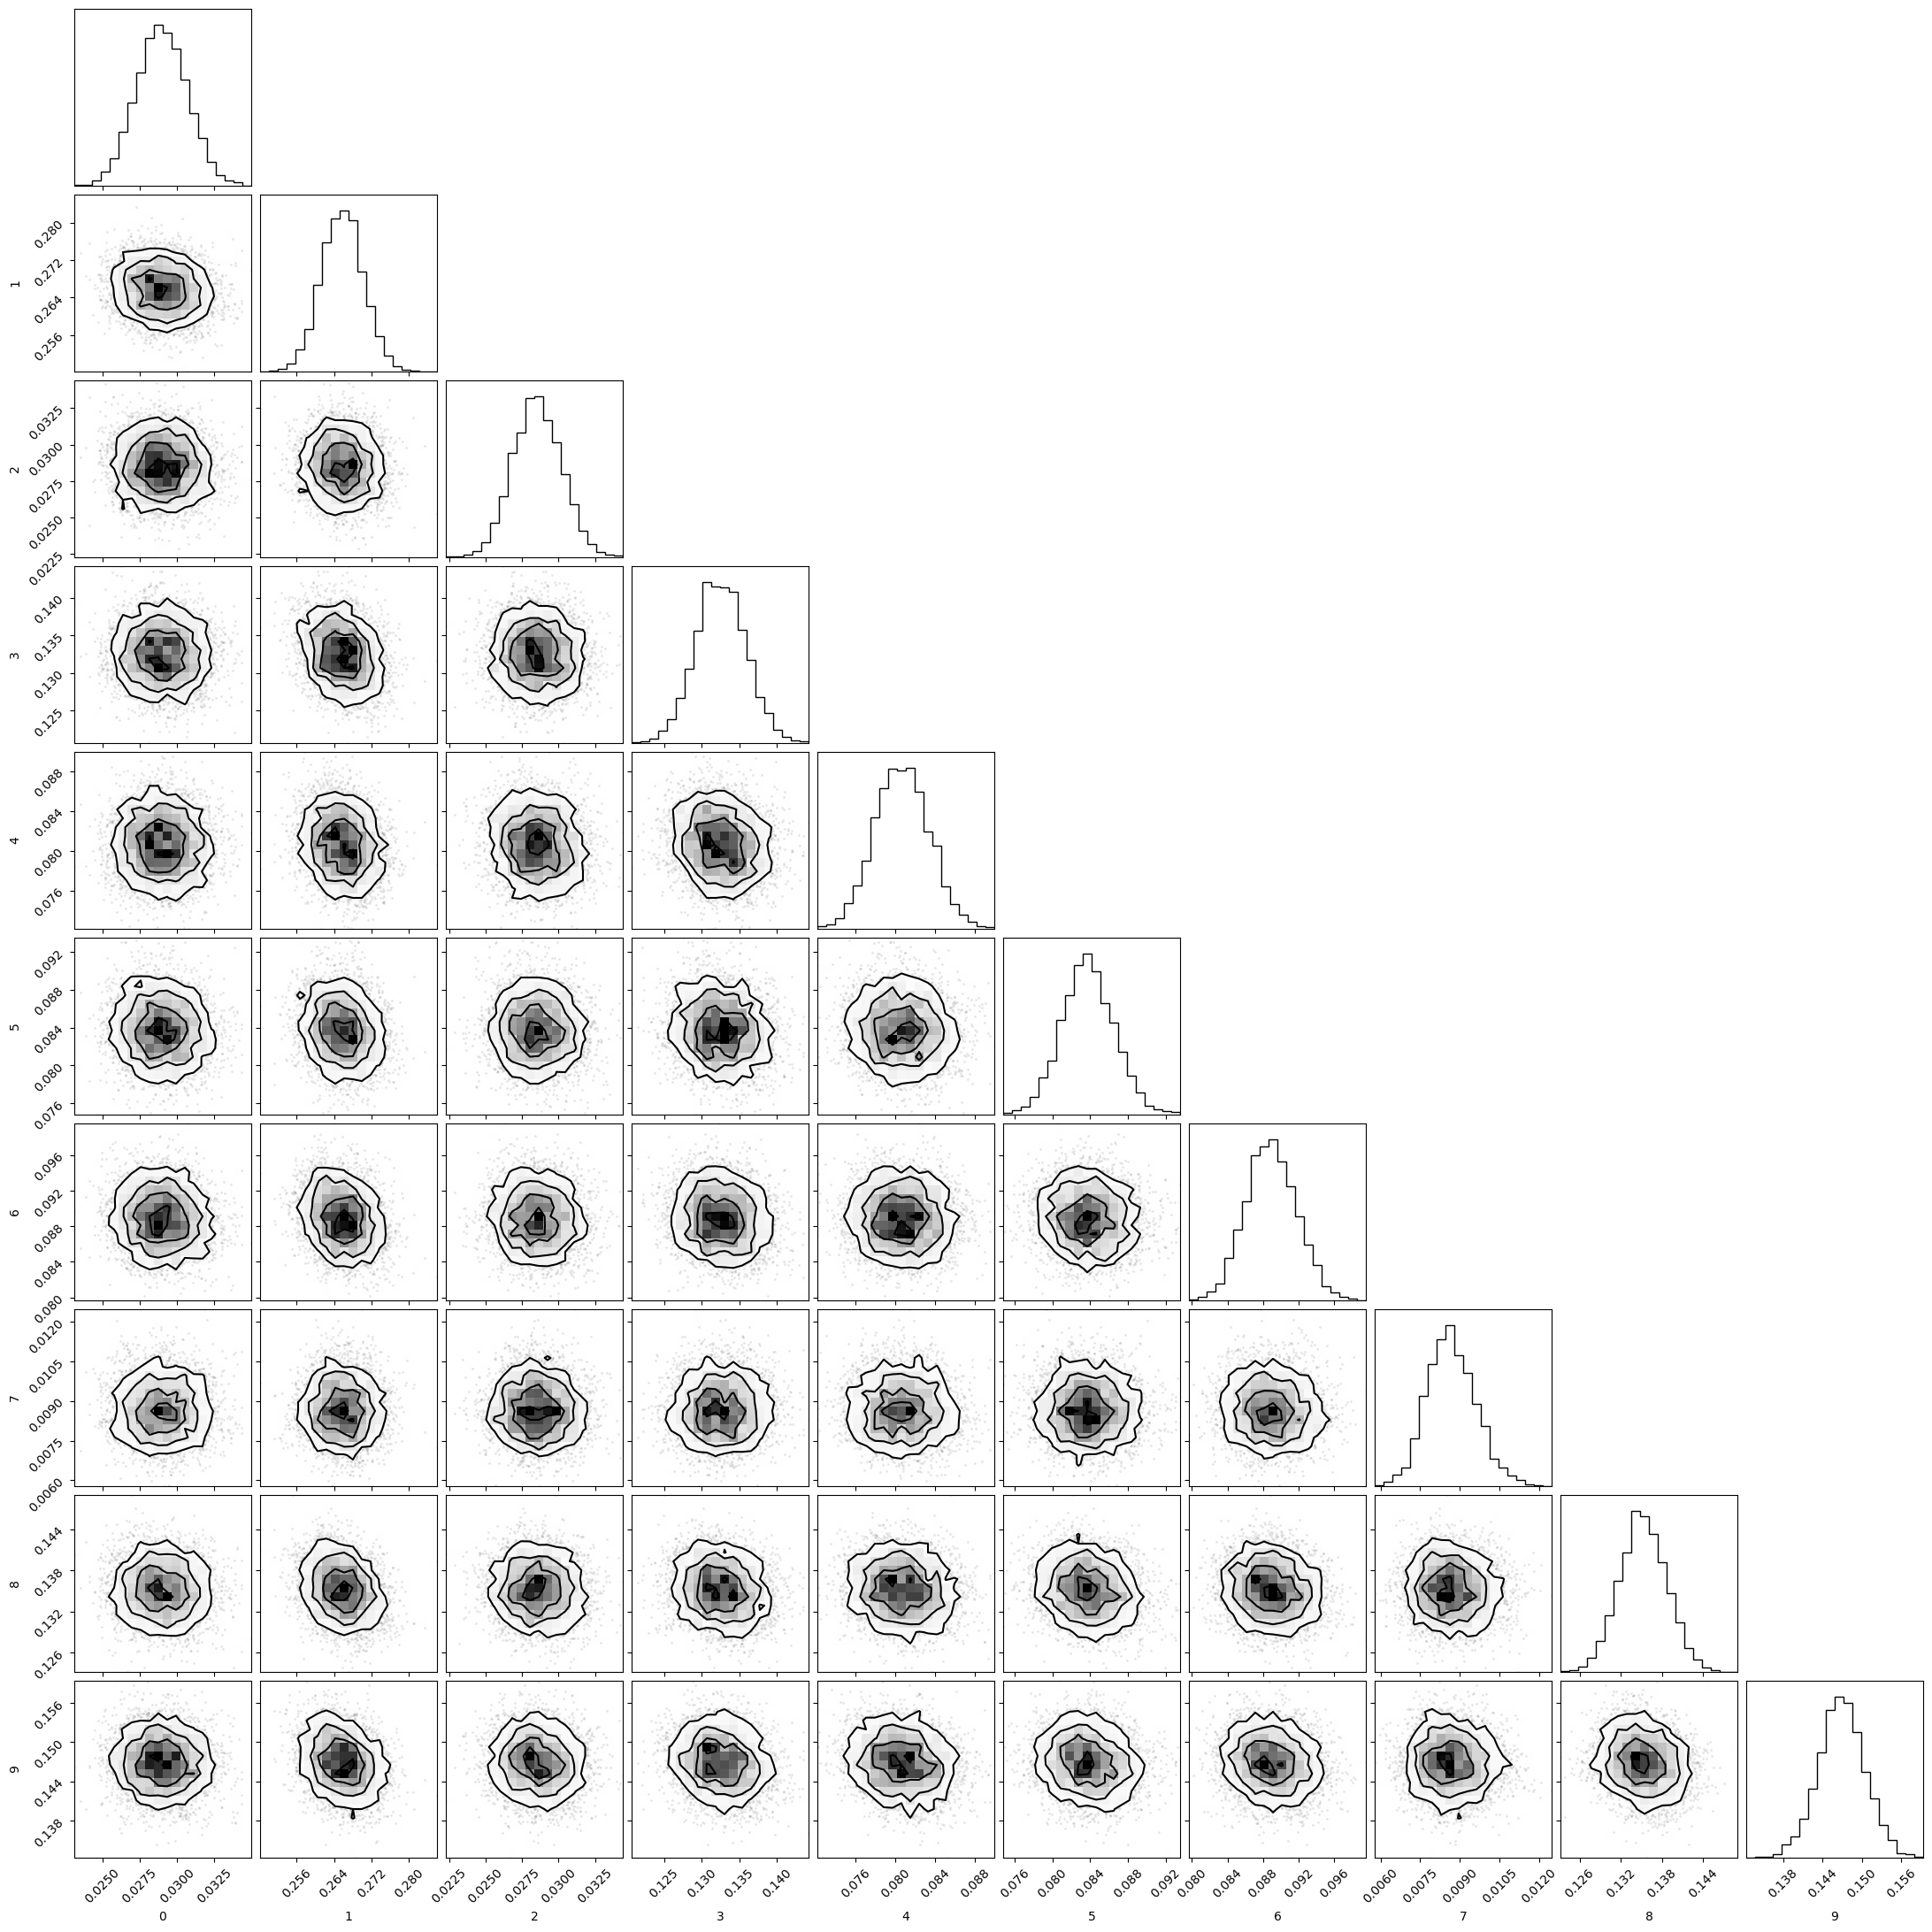

In [102]:
## make corner plot
log_weights_d = np.array(log_weights_d)
log_weights_d_flat = log_weights_d.reshape(-1, num_metastructures)
corner.corner(np.exp(log_weights_d_flat), labels=[str(i) for i in range(num_metastructures)])
plt.savefig(stan_directory + 'corner_plot.png')

In [103]:
import seaborn as sns

In [104]:
prob = np.exp(log_weights_d_flat)

In [105]:
# Convert the 2D array to a DataFrame
df = pd.DataFrame(data=prob)

# Melt the DataFrame to long format
df_melted = df.melt(var_name='Observation Index', value_name='Value')

In [106]:
df_melted

,Observation Index,Value
0,0,0.028965
1,0,0.031159
2,0,0.026402
3,0,0.028361
4,0,0.030414
...,...,...
39995,9,0.152149
39996,9,0.145516
39997,9,0.147396
39998,9,0.146133


In [107]:
true_weights_dir =  os.path.join(os.path.split(stan_directory)[0], 'true_weights.txt')
true_weights = np.loadtxt(true_weights_dir, delimiter=' ')

In [108]:
true_weights

array([0.029083, 0.268239, 0.025185, 0.143414, 0.08295 , 0.08365 ,
       0.092644, 0.003198, 0.134819, 0.136818])

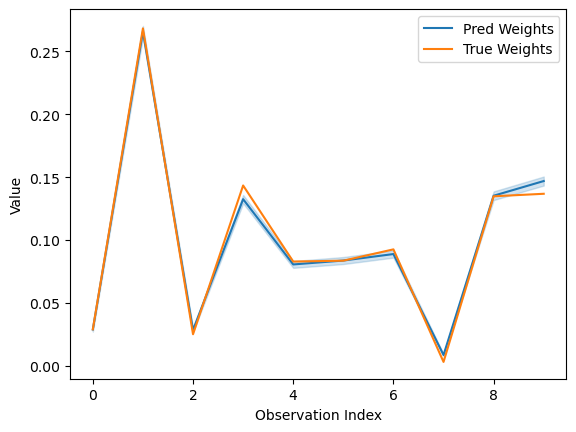

In [123]:
sns.lineplot(x='Observation Index', y='Value', data=df_melted, errorbar='sd', label='Pred Weights')
sns.lineplot(true_weights, label='True Weights')
plt.legend()

In [110]:
scipy.special.kl_div(true_weights, prob.mean(axis=0)).sum()

0.003410728151784296

In [20]:
def evaluate_kl_div(mcmc_result_folder):
    stan_directory = mcmc_result_folder
    
    log_weights = []
    lp = []
    files = sorted(os.listdir(stan_directory))[-4:]
    
    num_metastructures = extract_specific_number(stan_directory, 3)
    weight_dist = extract_specific_number(stan_directory, 4)
    noise_level = extract_specific_number(stan_directory, 5)
    
    log_weights_d = []
    for file in files:
        log_weights_chain = []
        lp_chain = []
        with open('%s/%s'%(stan_directory, file), newline='') as csvfile:
            reader = csv.DictReader(filter(lambda row: row[0]!='#', csvfile), )
            for row in reader:
                log_weights_row = [float(row["log_weights.%d"%i]) for i in range(1,num_metastructures+1)]
                lp_chain.append(float(row["lp__"]))
                log_weights_chain.append(log_weights_row)
        log_weights = np.array(log_weights_chain)
        lp_chain = np.array(lp_chain)
        log_weights_d.append(log_weights)
        lp.append(lp_chain)
    log_weights_d = np.array(log_weights_d)
    
    log_weights_d = np.array(log_weights_d)
    log_weights_d_flat = log_weights_d.reshape(-1, num_metastructures)
    
    # if num_metastructures <= 10:
    #     corner.corner(np.exp(log_weights_d_flat), labels=[str(i) for i in range(num_metastructures)]);
    #     plt.savefig(stan_directory + 'corner_plot.png');
        
    pred_weights = np.exp(log_weights_d_flat)
    true_weights_dir =  os.path.join(os.path.split(stan_directory)[0], 'true_weights.txt')
    true_weights = np.loadtxt(true_weights_dir, delimiter=' ')
    
    kl_div_list = [scipy.special.kl_div(true_weights, x).sum() for x in pred_weights]
    mse_list = [np.linalg.norm(true_weights - x).sum() for x in pred_weights]
    
    # generate a pandas dataframe that contain kl_div_list 
    # other 3 columns are num_metastructures, weight_dist, noise_level
    df = pd.DataFrame({'kl_div': kl_div_list, 
                       'mse': mse_list,
                       'num_metastructures': num_metastructures, 
                       'weight_dist': weight_dist, 
                       'noise_level': noise_level})
    
    return df 

In [21]:
df_list = [evaluate_kl_div(f) for f in tqdm(folders[:2000])]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [24]:
df_list_2 = [evaluate_kl_div(f) for f in tqdm(folders[2000:])]

  0%|          | 0/8091 [00:00<?, ?it/s]

In [25]:
df_all = pd.concat(df_list + df_list_2)

In [28]:
df_all.to_csv(os.path.join(results_dir, 'weight_mcmc_performance.csv'))

In [31]:
# calculate kl loss from two random set of numbers 
num_temp = np.arange(1, 501)
kl_loss_array = []
mse_loss_array = []
for iter in tqdm(range(1000)):
    kl_loss_list = []
    mse_loss_list = []
    for i in num_temp:
        random_number_1 = scipy.special.softmax(np.random.rand(i))
        random_number_2 = scipy.special.softmax(np.random.rand(i))
        kl_loss = np.sum(scipy.special.kl_div(random_number_1, random_number_2))
        kl_loss_list.append(kl_loss)
        mse_loss = np.linalg.norm(random_number_1 - random_number_2).sum() 
        mse_loss_list.append(mse_loss)
    kl_loss_array.append(kl_loss_list)
    mse_loss_array.append(mse_loss_list)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [34]:
kl_random_df = pd.DataFrame(kl_loss_array)
kl_random_df_melted = kl_random_df.melt(var_name='num_metastructures', value_name='kl_div')

In [41]:
mse_random_df = pd.DataFrame(mse_loss_array)
mse_random_df_melted = mse_random_df.melt(var_name='num_metastructures', value_name='mse')

<Axes: xlabel='num_metastructures', ylabel='kl_div'>

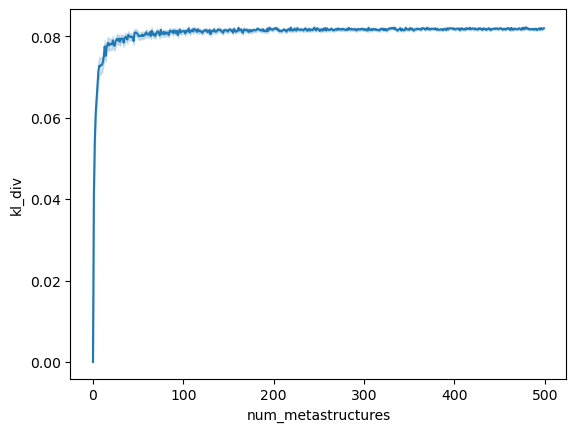

In [40]:
sns.lineplot(data=kl_random_df_melted, x='num_metastructures', y='kl_div')

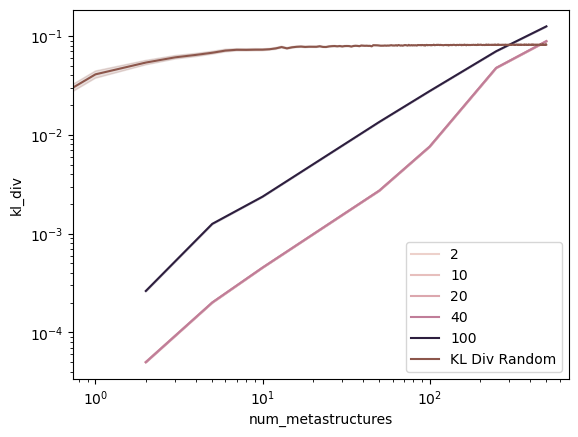

In [46]:
sns.lineplot(data=df_all, x='num_metastructures', y='kl_div', hue='noise_level')
sns.lineplot(data=kl_random_df_melted, x='num_metastructures', y='kl_div', label='KL Div Random')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.savefig(os.path.join(results_dir, 'kl_div_comparison.png'), dpi=300, bbox_inches='tight')

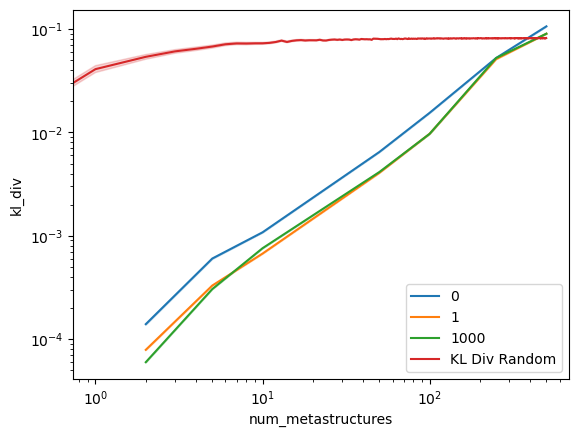

In [47]:
sns.lineplot(data=df_all, x='num_metastructures', y='kl_div', hue='weight_dist', palette='tab10')
sns.lineplot(data=kl_random_df_melted, x='num_metastructures', y='kl_div', label='KL Div Random')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.savefig(os.path.join(results_dir, 'kl_div_comparison_weight_dist.png'), dpi=300, bbox_inches='tight')

<Axes: xlabel='num_metastructures', ylabel='mse'>

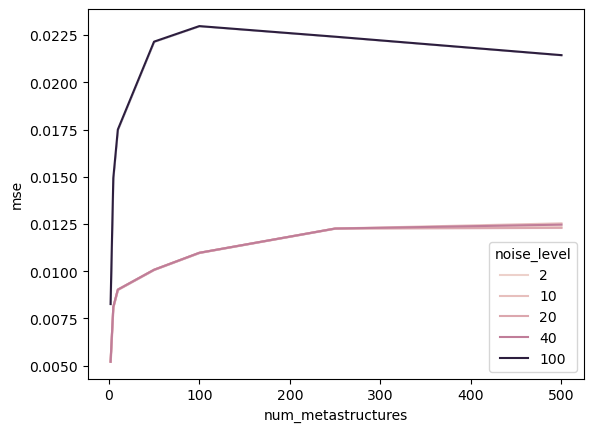

In [30]:
sns.lineplot(data=df_all, x='num_metastructures', y='mse', hue='noise_level')